In [29]:
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.sandbox.stats.multicomp import multipletests 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Измерены следующие признаки:

*    state — штат США
*    account_length — длительность использования аккаунта
*    area_code — деление пользователей на псевдорегионы, использующееся в телекоме
*    intl_plan — подключена ли у пользователя услуга международного общения
*    vmail_plan — подключена ли у пользователя услуга голосовых сообщений
*    vmail_message — количество голосых сообщений, который пользователь отправил / принял
*    day_calls — сколько пользователь совершил дневных звонков
*    day_mins — сколько пользователь проговорил минут в течение дня
*    day_charge — сколько пользователь заплатил за свою дневную активность
*    eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
*    night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
*    intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
*   custserv_calls — сколько раз пользователь позвонил в службу поддержки
*    treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
*    mes_estim — оценка интенсивности пользования интернет мессенджерами
*    churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [2]:
data = pd.read_csv("churn_analysis.csv")
data.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [3]:
data.describe()
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.churn.loc[data.churn == 'True.'] = True
data.churn.loc[data.churn == 'False.'] = False

Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции 

In [5]:
df_states = pd.pivot_table(data.loc[data.treatment == 1], values = 'treatment', 
                           index = 'state', columns = 'churn', aggfunc = len, fill_value = 0)
_values = pd.DataFrame(columns = ['state1', 'state2', 'chi_2_statistics', 'chi_2_corrected', 
                                      'p_val', 'p_val_corrected', 'fisher_stat'])
i = 0
for st1, st2 in combinations(df_states.index, 2):
        table = df_states.loc[[st1, st2], :]
        _values.loc[i, 'state1'] = st1
        _values.loc[i, 'state2'] = st2
        chi2_stat = stats.chi2_contingency(table.values, correction = False)
        chi2_stat_corr = stats.chi2_contingency(table.values, correction = True)
        _values.loc[i, 'chi_2_statistics'] = chi2_stat[0]
        _values.loc[i, 'p_val'] = chi2_stat[1]
        _values.loc[i, 'chi_2_corrected'] = chi2_stat_corr[0]
        _values.loc[i, 'p_val_corrected'] = chi2_stat_corr[1]
        fisher_stat = stats.fisher_exact(table.values)
        _values.loc[i, 'fisher_stat'] = fisher_stat[0]
        _values.loc[i, 'p-value_fisher'] = fisher_stat[1]
        i += 1

In [6]:
_values

,state1,state2,chi_2_statistics,chi_2_corrected,p_val,p_val_corrected,fisher_stat,p-value_fisher
0,AK,AL,1.54672,0.639205,0.213621,0.423999,3.8,0.381063
1,AK,AR,4.41,2.7225,0.0357288,0.0989429,8.63636,0.068862
2,AK,AZ,0.419079,0.00213816,0.517397,0.963119,2.23529,0.604990
3,AK,CA,4.84435,3.05496,0.0277369,0.0804911,9.5,0.063965
4,AK,CO,2.68864,1.4358,0.101066,0.230821,5.58824,0.187034
...,...,...,...,...,...,...,...,...
1270,WA,WV,1.72063,0.961945,0.189612,0.326697,0.42328,0.207829
1271,WA,WY,3.20158,2.00655,0.0735671,0.156622,0.228571,0.134552
1272,WI,WV,0.666667,0.166667,0.414216,0.683091,2.03704,0.686168
1273,WI,WY,0.00829726,0.187207,0.927422,0.665252,1.1,1.000000


In [8]:
print("Число p-value <= 0.05:",len(_values.loc[_values['p_val'] < 0.05, :]))
print("Число p-value (с коррекцией) <= 0.05:",len(_values.loc[_values['p_val_corrected'] < 0.05, :]))

Число p-value <= 0.05: 34
Число p-value (с коррекцией) <= 0.05: 0


В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то **дискретное** биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью **непрерывного** распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного $O_i$ и ожидаемого 
$E_i$ значений, то есть, статистика с такой поправкой выглядит так: χYates2=∑i=1N(|Oi−Ei|−0.5)2Ei.

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики χ2, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода). 

In [9]:
print('Pearson correlation: %.4f' % stats.pearsonr(data.day_calls, data.mes_estim)[0])
print('P-value: %.4f' % stats.pearsonr(data.day_calls, data.mes_estim)[1])

print('Spearman correlation: %.4f' % stats.spearmanr(data.day_calls, data.mes_estim)[0])
print('P-value: %.4f' % stats.spearmanr(data.day_calls, data.mes_estim)[1])

Pearson correlation: -0.0518
P-value: 0.0028
Spearman correlation: 0.0433
P-value: 0.0123


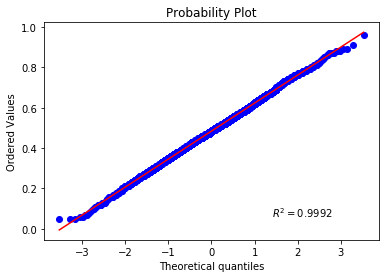

In [10]:
_ = stats.probplot(data.mes_estim, rvalue = True, plot = plt)

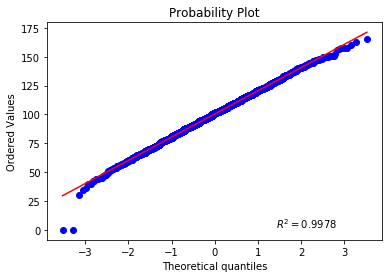

In [11]:
_ = stats.probplot(data.day_calls, rvalue = True, plot = plt)

In [12]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))
print('V Cramer stat value: %.4f' % cramers_stat(df_states.values))

V Cramer stat value: 0.2004


с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

In [16]:
df_states = pd.pivot_table(data, values = 'account_length', index = 'state', columns = ['treatment', 'churn'],
                           aggfunc = len, fill_value = 0)
df_states.head()

treatment     0           1           2      
churn     False True  False True  False True 
state                                        
AK           15     2    19     1    15     0
AL           22     1    25     5    25     2
AR           14     3    11     5    19     3
AZ           26     0    17     2    17     2
CA           10     3    10     5     5     1

In [23]:
#построим доверительный интервал для долей TRUE в каждой из подгрупп
proportions = np.array([
     df_states.loc[:, i].loc[:, True].sum() / (df_states.loc[:, i].loc[:, True].sum() 
     + df_states.loc[:, i].loc[:, False].sum()) for i in range(3)])
print("treatment(1, 2, 3) -- proportions of churn = 1 (1, 2, 3):\n", proportions)

treatment(1, 2, 3) -- proportions of churn = 1 (1, 2, 3):
 [0.14563107 0.16408387 0.12511333]


In [33]:
#построим доверительные интервалы Wilson'a и разности долей для независимых выборок
w_proportion = np.array([proportion_confint(df_states.loc[:, treat].loc[:, True].sum(),
                       (df_states.loc[:, treat].loc[:, False].sum() + df_states.loc[:, treat].loc[:, True].sum()),
                        method = 'wilson') for treat in range(3)])
print("treatment(1, 2, 3) -- Wilson proportions of churn = 1 (1, 2, 3):\n", w_proportion)

treatment(1, 2, 3) -- Wilson proportions of churn = 1 (1, 2, 3):
 [[0.12628913 0.16736788]
 [0.14334707 0.18716506]
 [0.1068801  0.14594876]]


In [37]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    l1 = sample1.loc[:, False].sum() + sample1.loc[:, True].sum()
    l2 = sample2.loc[:, False].sum() + sample2.loc[:, True].sum()
    p1 = sample1.loc[:, True].sum() / l1
    p2 = sample2.loc[:, True].sum() / l2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    l1 = sample1.loc[:, False].sum() + sample1.loc[:, True].sum()
    l2 = sample2.loc[:, False].sum() + sample2.loc[:, True].sum()
    p1 = sample1.loc[:, True].sum() / l1
    p2 = sample2.loc[:, True].sum() / l2
    P = (p1 * l1 + p2 * l2) / (l1 + l2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / l1 + 1. / l2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

p_val_table = np.empty((3, 3))
i = 0
for tr1, tr2 in combinations(range(3), 2):
    confint_diff = proportions_confint_diff_ind(df_states.loc[:, tr1], df_states.loc[:, tr2])
    print(tr1, tr2, confint_diff)
    p_val = proportions_diff_z_test(proportions_diff_z_stat_ind(df_states.loc[:, tr1], df_states.loc[:, tr2]))
    p_val_table[i, :] = int(tr1), int(tr2), p_val
    i += 1

p_val_table

0 1 (-0.04848883584089464, 0.011583241590025106)
0 2 (-0.007820886720395197, 0.04885636806430281)
1 2 (0.00961876673809212, 0.06832230885668503)


array([[0.        , 1.        , 0.22833116],
       [0.        , 2.        , 0.15642469],
       [1.        , 2.        , 0.00934808]])

In [38]:
#поправка на проверку гипотез по fdr
_, p_corrected, _, _ = multipletests(p_val_table[:, 2], alpha = 0.05, method = 'fdr_bh') 
p_corrected



array([0.22833116, 0.22833116, 0.02804425])